In [1]:
import pyspark
import pandas as pd
import numpy as np
import math

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, mean, column
import matplotlib.pyplot as plt
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
#from pyspark.mllib.recommendation import ALS

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import os

from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.util import MLUtils

from decision_tree_plot.decision_tree_parser import decision_tree_parse
from decision_tree_plot.decision_tree_plot import plot_trees

In [2]:
#ss = SparkSession.builder.master("local").config("spark.driver.memory", "16g").appName("PCAExample1").getOrCreate()
#ss = SparkSession.builder.config("spark.driver.memory", "5g").master("local").appName("PCAExample1").getOrCreate()
ss = SparkSession.builder.master("local").appName("PCAExample1").getOrCreate()

In [3]:
ss.sparkContext.setCheckpointDir("/storage/home/sxs6549/work/Project/scratch")

In [4]:
%%time
df_raw = ss.read.csv("wildfiredb.csv", header=True, inferSchema=True)
#df_raw = spark.read.csv("wildfire100.csv" , header = True, inferSchema = True)
column_names = df_raw.columns

#df_raw = df_raw.drop("acq_date")
df_raw = df_raw.dropna()

CPU times: user 45.6 ms, sys: 8.82 ms, total: 54.4 ms
Wall time: 2min 31s


In [5]:
#feature_columns = df_raw.columns
col_list = list(df_raw.columns)
feature_columns = list(set(col_list) - set(['_c0', 'Polygon_ID', 'acq_date']))

assembler = VectorAssembler(inputCols = feature_columns, outputCol =  "features")
assembled_data = assembler.transform(df_raw)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)

scaled_data = scaler_model.transform(assembled_data)

In [6]:
# Let us perform a hyperparameter sweep
# using 'features'
def variance_search():
    k_values = range(13, 20)  # Example: Try K from 2 to 10


    for k_val in k_values:
        #?
        #k = 2

        pca = PCA(k=k_val, inputCol = "scaled_features", outputCol ="pcaFeatures")
        model = pca.fit(scaled_data)
        result = model.transform(scaled_data)

        explained_variance = model.explainedVariance
        print("Explained Variance: ", sum(explained_variance), "K: Value: ", k_val)
#variance_search()

In [6]:
pca = PCA(k=36, inputCol="scaled_features", outputCol="pcaFeatures")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)

In [7]:
def fit_kmeans(df_input,column_name='pcaFeatures',num_cluster_centers=3):
    '''
    Requires
    df_input: spark dataframe with column name "features" having vector of real-valued inputs
    num_cluster_centers: integer that tells the algorithm the value of k
    column_name: column name (string) that indicates which vector of features to choose
    Returns
    cluster_data: spark dataframe with predictions
    silhouette_score: float with silhouette score
    wcss: float within cluster sum of squares
    '''
    # Create a K-Means instance
    kmeans = KMeans(featuresCol=column_name).setK(num_cluster_centers).setSeed(1)
    
    # Fit the K-Means model to the data
    model = kmeans.fit(df_input)
       
    # Get the cluster assignments for each data point
    clustered_data = model.transform(df_input)

    # Evaluate the clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)

    # Print the WCSS (Within-Cluster Sum of Squares)
    print(f"Silhouette Score: {silhouette_score}")
    wcss = model.summary.trainingCost
    print(f"Within cluster sum of squares: {wcss}")
    
    # Get the cluster sizes and centers
    cluster_sizes = clustered_data.groupBy("prediction").count()
    cluster_sizes.show()
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss

In [8]:
# Define a function to perform visualization
def visualize_clusters_2D(clustered_data, feature_1, feature_2,  num_cluster_centers=3):
    '''
    Requires:
    clustered_data: dataframe returned from Kmeans fit
    num_cluster_centers: integer number of clusters
    feature_1: string with identifiers for first column name
    feature_2: string with identifiers for second column name
    '''
    
    # Convert the DataFrame to a Pandas DataFrame for visualization
    pandas_df = clustered_data.select(feature_1, feature_2, "prediction").toPandas()
    
    # Extract the cluster assignments
    cluster_assignments = pandas_df["prediction"]
    
    # Extract the indices for the cluster center
    p1 = col_list.index(feature_1)
    p2 = col_list.index(feature_2)
    
    # Create a scatter plot for each cluster
    for cluster_id in range(num_cluster_centers):
        # Generate a random color
        random_color = generate_random_color()        
        cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
        plt.scatter(cluster_data[feature_1], cluster_data[feature_2], color=[random_color], label=f'Cluster {cluster_id}')
        plt.scatter(cluster_data[feature_1].mean(),cluster_data[feature_2].mean(), color=[random_color], marker='x', s=500)
    
    # Set labels and title
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title("K-Means Clustering")
    #Save figure to folder location
    
    mypath = "/storage/home/sxs6549/work/Project/graphs/"
    if not os.path.isdir(mypath):
       os.makedirs(mypath)
    #fig_name = "figure_frp_" + feature_1
    path = "/storage/home/sxs6549/work/Project/graphs/figure_frp_" + feature_1
    plt.savefig(path)
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

In [9]:
import random
def generate_random_color():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)

In [10]:
#def kmeans_loop():

#    k_values = range(3, 13)  # Example: Try K from 2 to 10

#    pca_silhouette_scores = []
#    pca_wcss_scores = []

#    for k in k_values:
#        clustered_data, sil, wcss = fit_kmeans(result,column_name='pcaFeatures',num_cluster_centers=k)
#        pca_silhouette_scores.append(sil)
#        pca_wcss_scores.append(wcss)
#    return pca_silhouette_scores, pca_wcss_scores
#kmeans_loop()

Silhouette Score: -0.0020533317479589216
Within cluster sum of squares: 473731605.89298344
+----------+------+
|prediction| count|
+----------+------+
|         1|470353|
|         2|980568|
|         0|916259|
+----------+------+

Silhouette Score: -0.15963946098487028
Within cluster sum of squares: 424046470.96653455
+----------+------+
|prediction| count|
+----------+------+
|         1|230626|
|         3|919490|
|         2|977131|
|         0|239933|
+----------+------+

Silhouette Score: -0.1720033456268473
Within cluster sum of squares: 385580682.76924366
+----------+------+
|prediction| count|
+----------+------+
|         1|225594|
|         3|634558|
|         4|227494|
|         2|589534|
|         0|690000|
+----------+------+

Silhouette Score: -0.18409268517246977
Within cluster sum of squares: 351140058.148487
+----------+------+
|prediction| count|
+----------+------+
|         1|208488|
|         3|427178|
|         5|734049|
|         4|503581|
|         2|212931|
| 

([-0.0020533317479589216,
  -0.15963946098487028,
  -0.1720033456268473,
  -0.18409268517246977,
  -0.18862840978343925,
  -0.191617109190983,
  -0.3446858379460037,
  -0.31886102692248797,
  -0.3550195236080584,
  -0.34053972383375697],
 [473731605.89298344,
  424046470.96653455,
  385580682.76924366,
  351140058.148487,
  337817574.6024609,
  330928657.1099426,
  309872289.8296143,
  297124919.2819469,
  287772185.23022616,
  283587878.3289545])

In [10]:
def kmeans_loop():
    #result.persist()
    k_values = range(3, 13)  # Example: Try K from 2 to 10

    pca_silhouette_scores = []
    pca_wcss_scores = []

    for k in k_values:
        clustered_data, sil, wcss = fit_kmeans(result,column_name='pcaFeatures',num_cluster_centers=k)
        pca_silhouette_scores.append(sil)
        pca_wcss_scores.append(wcss)
    return pca_silhouette_scores, pca_wcss_scores

#store_km_vals = kmeans_loop()

Silhouette Score: -0.002051685603785867
Within cluster sum of squares: 473768564.47975487
+----------+------+
|prediction| count|
+----------+------+
|         1|470364|
|         2|980310|
|         0|916506|
+----------+------+



ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/storage/home/sxs6549/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/storage/home/sxs6549/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
wcss_scores = store_km_vals[1]

In [ ]:
# Plot the Elbow Method curve
k_values = range(3, 13)
plt.plot(k_values, wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.savefig('elbow_chart')
plt.show()

Silhouette Score: -0.18517583088434597
Within cluster sum of squares: 443100587.72990435
+----------+------+
|prediction| count|
+----------+------+
|         1|207611|
|         3|212671|
|         5|744854|
|         4|418629|
|         2|501193|
|         0|282222|
+----------+------+



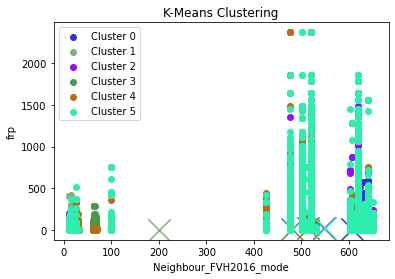

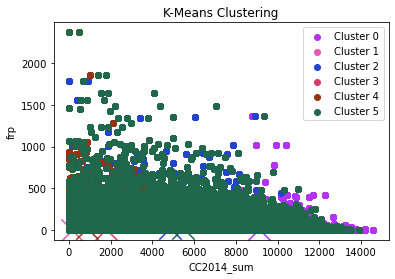

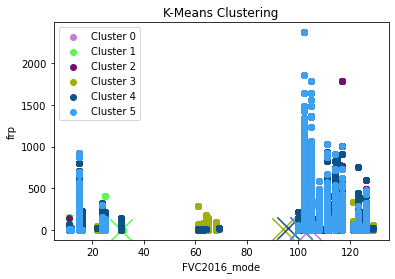

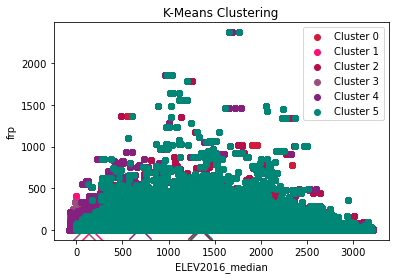

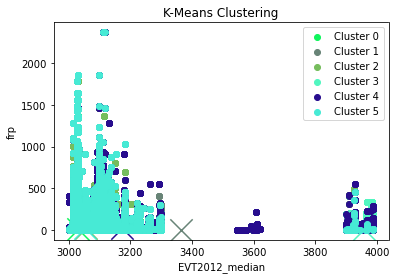

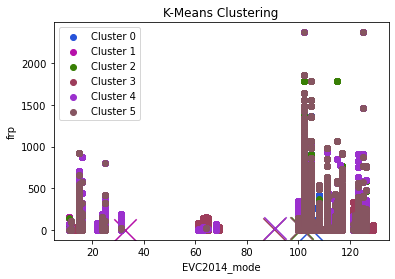

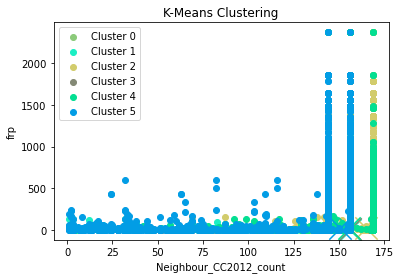

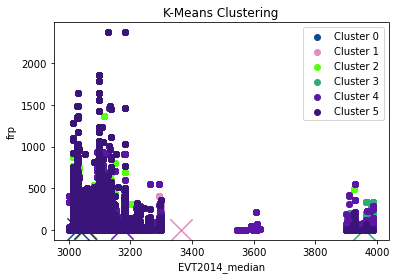

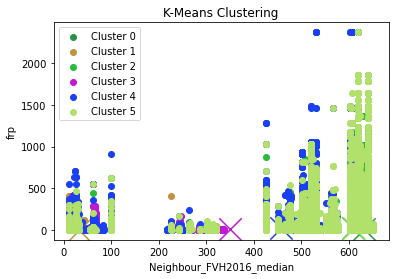

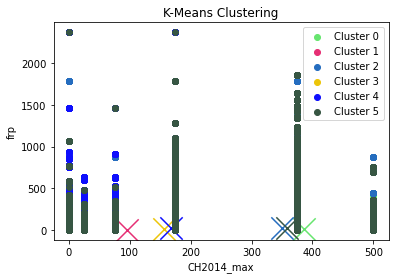

/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


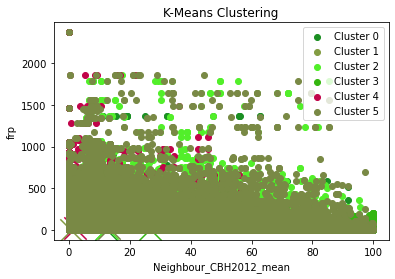

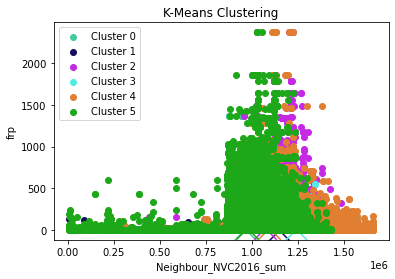

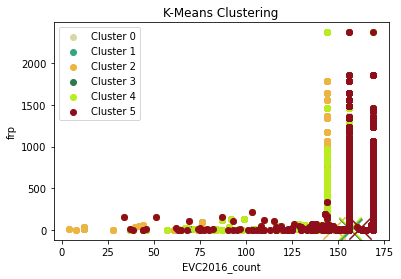

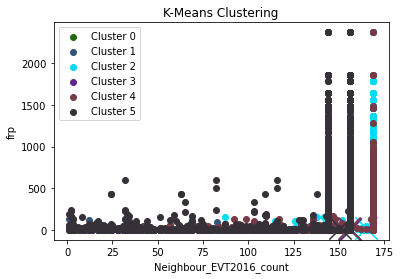

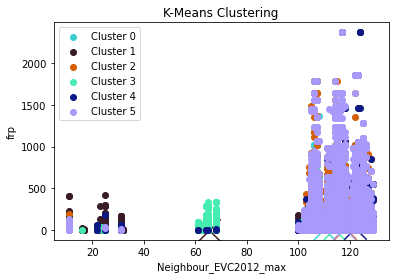

In [ ]:
# Let us perform a hyperparameter sweep
# using 'features'
def kmeans_vis_loop():

    #k_values = range(3, 13)  # Example: Try K from 2 to 10
    k_value = 6
    pca_silhouette_scores = []
    pca_wcss_scores = []

    #for k in k_values:
    clustered_data, sil, wcss = fit_kmeans(result,column_name='pcaFeatures',num_cluster_centers=k_value)
    

    for feature in feature_columns:
        #?
        #k = 2
        # Convert the DataFrame to a Pandas DataFrame for visualization
        feature_1 = feature
        feature_2 = "frp"
        #print("X")
        visualize_clusters_2D(clustered_data, feature_1, feature_2, k_value)
kmeans_vis_loop()

In [ ]:
#feature_columns = df_raw.columns
#col_list = list(df_raw.columns)
#col_list = list(df_raw_trial.columns)
feature_inputs = list(set(col_list) - set(['_c0', 'Polygon_ID', 'acq_date', 'frp']))

assembler_tree = VectorAssembler(inputCols = feature_inputs, outputCol =  "features")
#assembled_data_tree = assembler_tree.transform(df_raw_trial)
assembled_data_tree = assembler_tree.transform(df_raw)
#scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
#scaler_model = scaler.fit(assembled_data)

#scaled_data = scaler_model.transform(assembled_data)

In [ ]:
def tree_hyperparam_loop(data, model_path):

    (trainingData, testingData) = data.randomSplit([0.8, 0.2], seed=1237)


    ## Initialize a Pandas DataFrame to store evaluation results of all combination of hyper-parameter settings
    hyperparams_eval_df = pd.DataFrame( columns = ['max_depth', 'minInstancesPerNode', 'training_rmse', 'testing_rmse',  'Best Model'] )
    # initialize index to the hyperparam_eval_df to 0
    index =0 
    # initialize lowest_error
    lowest_testing_rmse = 100000
    # Set up the possible hyperparameter values to be evaluated
    max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    minInstancesPerNode_list = [2, 3, 4, 5, 6, 7]
    #max_depth_list = [2]
    #minInstancesPerNode_list = [9]
    #labelIndexer = StringIndexer(inputCol="class", outputCol="indexedLabel").fit(data2)
    #feature_inputs = list(set(col_list) - set(['_c0', 'Polygon_ID', 'acq_date', 'frp']))
    #assembler = VectorAssembler( inputCols=feature_inputs, outputCol="features")
    #labelConverter = IndexToString(inputCol = "prediction", outputCol="predictedClass", labels=labelIndexer.labels)
    #model_path="/storage/home/sxs6549/work/Project/DTmodel_vis"
    trainingData.persist()
    testingData.persist()


    for max_depth in max_depth_list:
        for minInsPN in minInstancesPerNode_list:
            trainingData.persist()
            testingData.persist()
            
            seed = 37
            # Construct a DT model using a set of hyper-parameter values and training data
            #dt= DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="features", maxDepth= max_depth, minInstancesPerNode= minInsPN)
            dt = DecisionTreeRegressor(labelCol="frp", featuresCol="pcaFeatures", maxDepth=max_depth, minInstancesPerNode=minInsPN)
            #pipeline = Pipeline(stages=[labelIndexer, assembler, dt, predictionConverter])
            model = dt.fit(trainingData)
            training_predictions = model.transform(trainingData)
            testing_predictions = model.transform(testingData)
            #evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
            evaluator = RegressionEvaluator(labelCol="frp", predictionCol="prediction", metricName="rmse")
            training_rmse = evaluator.evaluate(training_predictions)
            testing_rmse = evaluator.evaluate(testing_predictions)
            # We use 0 as default value of the 'Best Model' column in the Pandas DataFrame.
            # The best model will have a value 1000
            hyperparams_eval_df.loc[index] = [ max_depth, minInsPN, training_rmse, testing_rmse, 0]  
            index = index +1
            if testing_rmse < lowest_testing_rmse :
                best_max_depth = max_depth
                best_minInsPN = minInsPN
                best_index = index -1
                best_parameters_training_rmse = training_rmse
                best_DTmodel= model
                best_tree = decision_tree_parse(best_DTmodel, ss, model_path)
                column = dict( [ (str(idx), i) for idx, i in enumerate(feature_inputs) ])           
                lowest_testing_rmse = testing_rmse
    print('The best max_depth is ', best_max_depth, ', best minInstancesPerNode = ', \
          best_minInsPN, ', testing rmse = ', lowest_testing_rmse) 
    column = dict([(str(idx), i) for idx, i in enumerate(feature_inputs)])

    
    best_model_path_part7="/storage/home/sxs6549/work/Project/DT_HPT_cluster"
    best_tree=decision_tree_parse(best_DTmodel, ss, best_model_path_part7)
    column = dict([(str(idx), i) for idx, i in enumerate(feature_inputs)])
    plot_trees(best_tree, column = column, output_path = '/storage/home/sxs6549/work/Project/DT_HPT_cluster.html')
    hyperparams_eval_df.loc[best_index]=[best_max_depth, best_minInsPN, best_parameters_training_rmse, lowest_testing_rmse, 1000]
    output_path = "/storage/home/sxs6549/work/Project/HPT_cluster.csv"
    hyperparams_eval_df.to_csv(output_path)  
    
tree_hyperparam_loop(result_tree, model_path="/storage/home/sxs6549/work/Project/DTmodel_vis")